In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.integrate import odeint

In [ ]:
df_Me = pd.read_excel(r'/Users/caterina/Documents/TU:e/CPT/Process Tech/python intro/Cp_methanol.xlsx')
df_Iso = pd.read_excel(r'/Users/caterina/Documents/TU:e/CPT/Process Tech/python intro/Cp_isopropanol.xlsx')

In [2]:
# Heat Capacity Methanol
# Getting data from file and making fitted line
Temp_list_Me = df_Me['Temperature'].values.tolist()
Cp_list_Me = df_Me['Cp'].values.tolist()
a_Me, b_Me, c_Me = np.polyfit(Temp_list_Me, Cp_list_Me, deg=2)

'''plt.plot(Temp_list_Me, Cp_list_Me, "o")
plt.plot(Temp_list_Me, np.polyval((a_Me, b_Me, c_Me),Temp_list_Me), "-")
plt.xlabel('T[K]')
plt.ylabel('Cp') 
plt.title('Methanol heat capacity')
plt.show()'''

# Heat Capacity Isopropanol
# Getting data and making fitted line
Temp_list_Iso = df_Iso['Temp'].values.tolist()
Cp_list_Iso = df_Iso['Cp'].values.tolist()
a_Iso, b_Iso, c_Iso = np.polyfit(Temp_list_Iso, Cp_list_Iso, deg=2)
Temps_Iso_model = np.linspace(-20, 85, 22)
Temps_Iso_model_K  = [x+273.15 for x in Temps_Iso_model] # convert to Kelvin

'''plt.plot(Temp_list_Iso, Cp_list_Iso, "o")
plt.plot(Temps_Iso_model_K, np.polyval((a_Iso, b_Iso, c_Iso), Temps_Iso_model_K), "-")
plt.xlabel('T[K]') # label on the x axis
plt.ylabel('Cp') # label on the y axis
plt.title('Isopropanol heat capacity')
plt.show()'''

'plt.plot(Temp_list_Iso, Cp_list_Iso, "o")\nplt.plot(Temps_Iso_model_K, np.polyval((a_Iso, b_Iso, c_Iso), Temps_Iso_model_K), "-")\nplt.xlabel(\'T[K]\') # label on the x axis\nplt.ylabel(\'Cp\') # label on the y axis\nplt.title(\'Isopropanol heat capacity\')\nplt.show()'

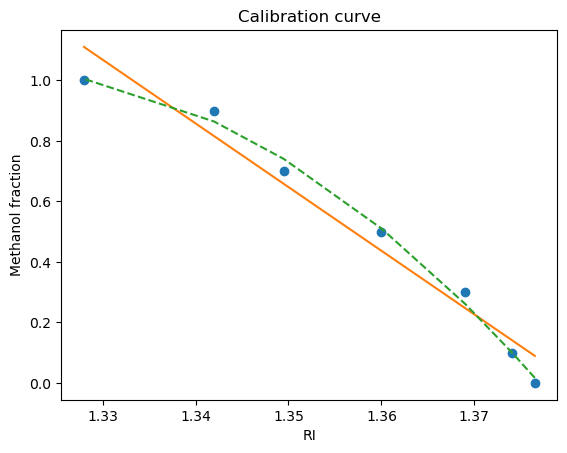

0.5105995532411498


In [3]:
# Refractive Index Calibration Curve

#Measurements
Me_fraction = [0, 0.1, 0.3, 0.5, 0.7, 0.9, 1]
RI = [1.3765, 1.374, 1.369, 1.360, 1.3495, 1.342, 1.328]

#fitting line at multiple degrees
Cal_a_fit, Cal_b_fit = np.polyfit(RI, Me_fraction, deg=1)
Cal_a_fit2, Cal_b_fit2, Cal_c_fit2 = np.polyfit(RI, Me_fraction, deg=2)

plt.plot(RI, Me_fraction,"o")
plt.plot(RI, np.polyval((Cal_a_fit, Cal_b_fit), RI),"-")
plt.plot(RI, np.polyval((Cal_a_fit2, Cal_b_fit2, Cal_c_fit2), RI), "--")
plt.xlabel("RI")
plt.ylabel("Methanol fraction")
plt.title('Calibration curve')
plt.show()

def Calibration(RI):
    Me_ratio = RI**2 * Cal_a_fit2 + RI*Cal_b_fit2 + Cal_c_fit2
    return Me_ratio

#use calibration function to get the methanol fraction
Me_frac = Calibration(1.36)
print(Me_frac)

In [4]:
# Constants for entire system 
p_atm = 101.325  # Atmospheric pressure in Pa
R = 8.3144598    # Gas constant J/molK

# Mass transfer coefficients 
k_me =  (10**3.4) * ((1.0020+1.2598)/2)*10**(-7) #m/s 
k_iso = (10**3.4)* ((2.47+3.17)/2)*10**(-10)     #m/s

In [ ]:
# Reboiler info 
A_r = 5                  # Evaporation surface area m2
dH_vap_Me = 37600        # Enthalpy of vaporisation methanol at boiling point [J/mol]
dH_vap_iso = 45*10**3
eff = 1 #640/751         # Heater efficiency (around 0.85)
T0 = 298                 #K
V  = 0.01                # Volume of mixture in reboiler [m^3]
Iso_frac = 1-Me_frac     # Mole fraction isopropanol
dens_Me = 792            #kg/m3
dens_Iso = 786           #kg/m3
M_Me = 32.02             #g/mol
M_Iso = 60.1             #g/mol
Vm_Me = 40.75            # molar volume methanol [cm^3/mol]
Vm = (M_Me/1000/dens_Me)*Me_frac + (M_Iso/1000/dens_Iso)*(1-Me_frac) # Molar volume of mixture [m^3/mol]
n_total = V/Vm           # Total number of moles in mixture
n_Me = Me_frac*n_total   # Number of moles of methanol
n_Iso = Iso_frac*n_total # Number of moles of isopropanol
dens_mix = (n_Me*M_Me + n_Iso*M_Iso)/V # Density of mixture [kg/m^3]
M_mix = (n_Me*M_Me + n_Iso*M_Iso)/1000 #kg/mol
power_percent = 0.7
power = eff*power_percent*2000 #J/s (maximum power is 2kW)

In [5]:
# Heat capacity
def Cp_Iso(T):
    Cp_Iso = a_Iso * T**2 + b_Iso*T + c_Iso
    return Cp_Iso

def Cp_Me(T):
    Cp_Me = a_Me * T**2 + b_Me * T + c_Me
    return Cp_Me

def Cp_mix(Me_frac,T):
    Cp_mix = Me_frac*Cp_Me(T) + (1-Me_frac)*Cp_Iso(T)
    return Cp_mix


# Vapor pressure for both compounds in the reboiler
def p0_me(T):
    #Antonie constants-methanol 
    A_me = 5.20409
    B_me = 1581.341
    C_me = -33.50
    #vapour pressure 
    p0_me = (10**(A_me - B_me/(T+C_me)))*10**5     #Pa
    return p0_me   


def p0_iso(T):
    #Antoine constants isopropanol
    A_iso = 4.8610
    B_iso =	1357.427
    C_iso = -75.814
    #vapour pressure 
    p0_iso = (10**(A_iso - B_iso/(T+C_iso)))*10**5    #Pa
    return p0_iso


In [8]:
# Condenser info 
T_cool = 289.15  # Temperature in K
A_c = 1          # Evaporation surface area m2

#Antonie constants methanol 
A_me = 5.20409
B_me = 1581.341
C_me = -33.50
    
#Antoine constants isopropanol
A_iso = 4.8610
B_iso =	1357.427
C_iso = -75.814

# Partial pressure with constant T_cool
p0_me_condens = (10**(A_me - B_me/(T_cool+C_me)))*10**5  
p0_iso_condens = (10**(A_iso - B_iso/(T_cool+C_iso)))*10**5 

In [9]:
params = {
    'Me_frac': Me_frac,   
    'n_total': n_total,
    'power': power,
    'A_r': A_r, 
    'R': R,        # Gas constant
    'k_me': k_me,  # mass coefficient methanol,
    'k_iso': k_iso, # mass coefficient isopropanol
    'p_atm': p_atm,
    'dH_vap_Me': dH_vap_Me,
    'A_c': A_c,
    'T_cool': T_cool,
    'p0_me_condens': p0_me_condens,
    'p0_iso_condens': p0_iso_condens
}

In [25]:
def modelODE(N,t,params):
    T_cool = params['T_cool']
    A_r = params['A_r']
    A_c = params['A_c']
    k_me = params['k_me']
    k_iso = params['k_iso']
    p_atm = params['p_atm']
    Me_frac = params['Me_frac']
    power = params['power']
    p0_me_condens = params['p0_me_condens']
    p0_iso_condens = params['p0_iso_condens']

    Nme_L = N[0]
    Niso_L = N[1]
    Nme_v = N[2]
    Niso_v = N[3]
    T = N[4]
    
    #mol fractions 
    y_me = Nme_v/(Niso_v+Nme_v)
    x_me = Nme_L/(Nme_L+Niso_L)
    y_iso = Niso_v/(Niso_v+Nme_v)
    x_iso = Niso_L/(Nme_L+Niso_L)
    
    dNdt = np.zeros(5)
    
    if T < 337.8:
        dNdt[0] = -k_me*A_r * ((x_me*p0_me(T) - p_atm*y_me)/(R*T)) + k_me*A_c * ((x_me*p0_me_condens - p_atm*y_me)/(R*T_cool))           #meL
        dNdt[1] = -k_iso*A_r * ((x_iso*p0_iso(T) - p_atm*y_iso)/(R*T)) + k_iso*A_c * ((x_iso*p0_me_condens - p_atm*y_iso)/(R*T_cool))   #isoL
        dNdt[2] = - dNdt[0]           #meV
        dNdt[3] =  - dNdt[1]         #isoV
        dNdt[4] =   (power)/(Cp_mix(x_me,T)*(Nme_L+Niso_L) + (dNdt[2])*dH_vap_Me + (dNdt[3])*dH_vap_iso)
    else:
        dNdt[0] = -k_me*A_r * ((x_me*p0_me(T) - p_atm*y_me)/(R*T)) + k_me*A_c * ((x_me*p0_iso_condens - p_atm*y_me)/(R*T_cool))           #meL
        dNdt[1] = -k_iso*A_r * ((x_iso*p0_iso(T) - p_atm*y_iso)/(R*T)) + k_iso*A_c * ((x_iso*p0_iso_condens - p_atm*y_iso)/(R*T_cool))   #isoL
        dNdt[2] = - dNdt[0]           #meV
        dNdt[3] =  - dNdt[1]         #isoV
        dNdt[4] =   0
    
    return dNdt


In [29]:
N_initial = [115, 115, 0.001, 0.001, 293] # meL isoL meV isoV
tspan = np.linspace(0, 1000, 10000)
N = odeint(modelODE, N_initial, tspan, args = (params,))

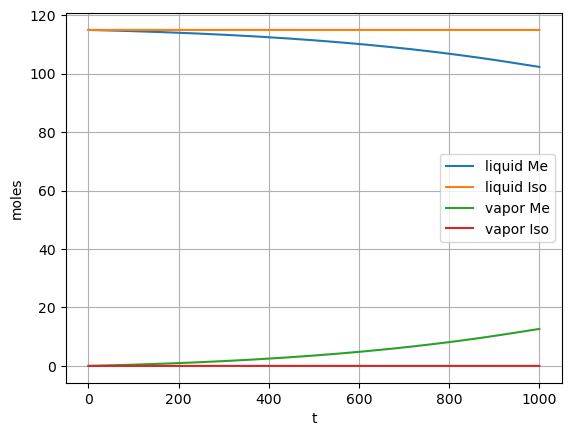

In [31]:
plt.plot(tspan, N[:,0], label = 'liquid Me')
plt.plot(tspan, N[:,1], label = 'liquid Iso')
plt.plot(tspan, N[:,2], label = 'vapor Me')
plt.plot(tspan, N[:,3], label = 'vapor Iso')
plt.legend()
plt.xlabel("t")
plt.ylabel("moles")
plt.grid()
plt.show()

In [ ]:
plt.plot(tspan,N[:,4])

In [ ]:
Temperature = N[:,4]
Temperature  = list(Temperature)
res = next(x for x, val in enumerate(Temperature)
                                    if val>337.8)
list2 = [Temperature.index(i) for i in Temperature if i >= 337.8]
list2[0]


In [ ]:
Temperature.index()

In [ ]:
Temperature

In [ ]:

plt.plot(t, y, "h", mfc='none', label='y(t) odeint', c="magenta")
plt.axhline(337.8, c="b") # boiling point methanol
plt.axhline(355.6, c="r") # boiling point isopropanol
plt.xlabel("t(s)")
plt.ylabel("T(K)")
plt.title("Mixture warming up", c="navy")
plt.grid(1)
plt.show()

# Time needed to evaporate all methanol (after boiling point is reached)
t_evap = n_Me*dH_vap_Me/power
print(t_evap)

boilup_rate = n_Me*Vm_Me/t_evap
print(boilup_rate)